# Creating a graph of collaborations with Israel and other countries

Displaying collaboration data between countries by year

In [1]:
import pandas as pd
df = pd.read_csv("../data/collaboration/country_edges.csv")
df_2021 = df[df['year'] == 2021]
df_2021.head(5)

,year,country_1,country_2,weight
240687,2021,China,United States,74348
240688,2021,United Kingdom,United States,54478
240689,2021,Germany,United States,39272
240690,2021,Canada,United States,37746
240691,2021,France,United States,27907


Showing collaboration data with Israel only

In [2]:
df_2021_il = df_2021[(df_2021['country_1'] == 'Israel') | (df_2021['country_2'] == 'Israel')]
top_10 = df_2021_il.nlargest(10, 'weight')

print(top_10)

        year  country_1       country_2  weight
240732  2021     Israel   United States    8497
240872  2021    Germany          Israel    2785
240878  2021     Israel  United Kingdom    2708
240941  2021     Israel           Italy    1937
240964  2021     France          Israel    1796
240987  2021     Canada          Israel    1645
241010  2021      China          Israel    1546
241044  2021     Israel           Spain    1389
241109  2021     Israel     Netherlands    1164
241133  2021  Australia          Israel    1077


Building a 2-depth collaboration graph from Israel

Preparing the data for the graph

In [6]:
import pandas as pd
from typing import Dict, Set, List

def two_hop_top_collabs(
    df: pd.DataFrame,
    target_country: str = "Israel",
    top_k: int = 10
) -> pd.DataFrame:
    """
    Build a two-hop subgraph around target_country for each year.
    Step 1: keep the top_k strongest partners of target_country per year.
    Step 2: for each of those partners, keep their own top_k strongest partners per year.
    Input df columns: ['year', 'country_1', 'country_2', 'weight'].
    Output df columns: ['year', 'country_1', 'country_2', 'weight'] with no duplicates.

    Notes:
    - Pairs are treated as unordered. The input is assumed to contain only one orientation per pair.
    - If duplicates exist in the input for the same (year, pair), they are aggregated by sum.
    """

    # Basic hygiene
    d = df.copy()
    d = d.rename(columns={"publication_year": "year"})  # allow either name
    d = d[["year", "country_1", "country_2", "weight"]].copy()
    d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")
    d["country_1"] = d["country_1"].astype(str)
    d["country_2"] = d["country_2"].astype(str)
    d["weight"] = pd.to_numeric(d["weight"], errors="coerce")

    # Drop self loops and missing rows
    d = d.dropna(subset=["year", "country_1", "country_2", "weight"])
    d = d[d["country_1"] != d["country_2"]]

    # Optional aggregation if the same pair appears more than once per year
    # Keep one record per (year, unordered pair)
    country_a = d[["country_1", "country_2"]].min(axis=1)
    country_b = d[["country_1", "country_2"]].max(axis=1)
    d = (
        pd.DataFrame({
            "year": d["year"].values,
            "country_a": country_a.values,
            "country_b": country_b.values,
            "weight": d["weight"].values
        })
        .groupby(["year", "country_a", "country_b"], as_index=False)["weight"].sum()
        .rename(columns={"country_a": "country_1", "country_b": "country_2"})
    )

    years = d["year"].dropna().unique()
    results: List[pd.DataFrame] = []

    for y in years:
        dy = d[d["year"] == y]

        # Step 1: top partners of target_country in year y
        with_target = dy[(dy["country_1"] == target_country) | (dy["country_2"] == target_country)].copy()
        if with_target.empty:
            continue

        # Extract "partner" column
        with_target["partner"] = with_target.apply(
            lambda r: r["country_2"] if r["country_1"] == target_country else r["country_1"], axis=1
        )
        top_target_partners = (
            with_target.sort_values("weight", ascending=False)
            .head(top_k)["partner"]
            .tolist()
        )
        # Keep step 1 edges
        step1 = with_target.sort_values("weight", ascending=False).head(top_k)[["year", "country_1", "country_2", "weight"]]
        top_k = 0
        # Step 2: for each partner, keep its own top_k partners in year y
        step2_list: List[pd.DataFrame] = []
        dy_sorted = dy.sort_values("weight", ascending=False)

        for partner in top_target_partners:
            # edges where this partner is incident
            p_edges = dy_sorted[(dy_sorted["country_1"] == partner) | (dy_sorted["country_2"] == partner)]
            if p_edges.empty:
                continue
            # take top_k for that partner
            step2_list.append(p_edges.head(top_k)[["year", "country_1", "country_2", "weight"]])

        step2 = pd.concat(step2_list, ignore_index=True) if step2_list else pd.DataFrame(columns=["year","country_1","country_2","weight"])

        # Combine and drop duplicates once more within the year
        combined_y = pd.concat([step1, step2], ignore_index=True)

        # Enforce unordered uniqueness
        ca = combined_y[["country_1", "country_2"]].min(axis=1)
        cb = combined_y[["country_1", "country_2"]].max(axis=1)
        combined_y = (
            pd.DataFrame({
                "year": combined_y["year"].values,
                "country_1": ca.values,
                "country_2": cb.values,
                "weight": combined_y["weight"].values
            })
            .drop_duplicates(subset=["year", "country_1", "country_2"], keep="first")
        )

        results.append(combined_y)

    if not results:
        return pd.DataFrame(columns=["year","country_1","country_2","weight"])

    out = pd.concat(results, ignore_index=True)

    # Sort for readability
    out = out.sort_values(by=["year", "weight"], ascending=[True, False]).reset_index(drop=True)
    return out

edge_list = two_hop_top_collabs(df_2021, target_country="Israel", top_k=10)


Drawing the graph

Graph: 11 nodes, 10 edges


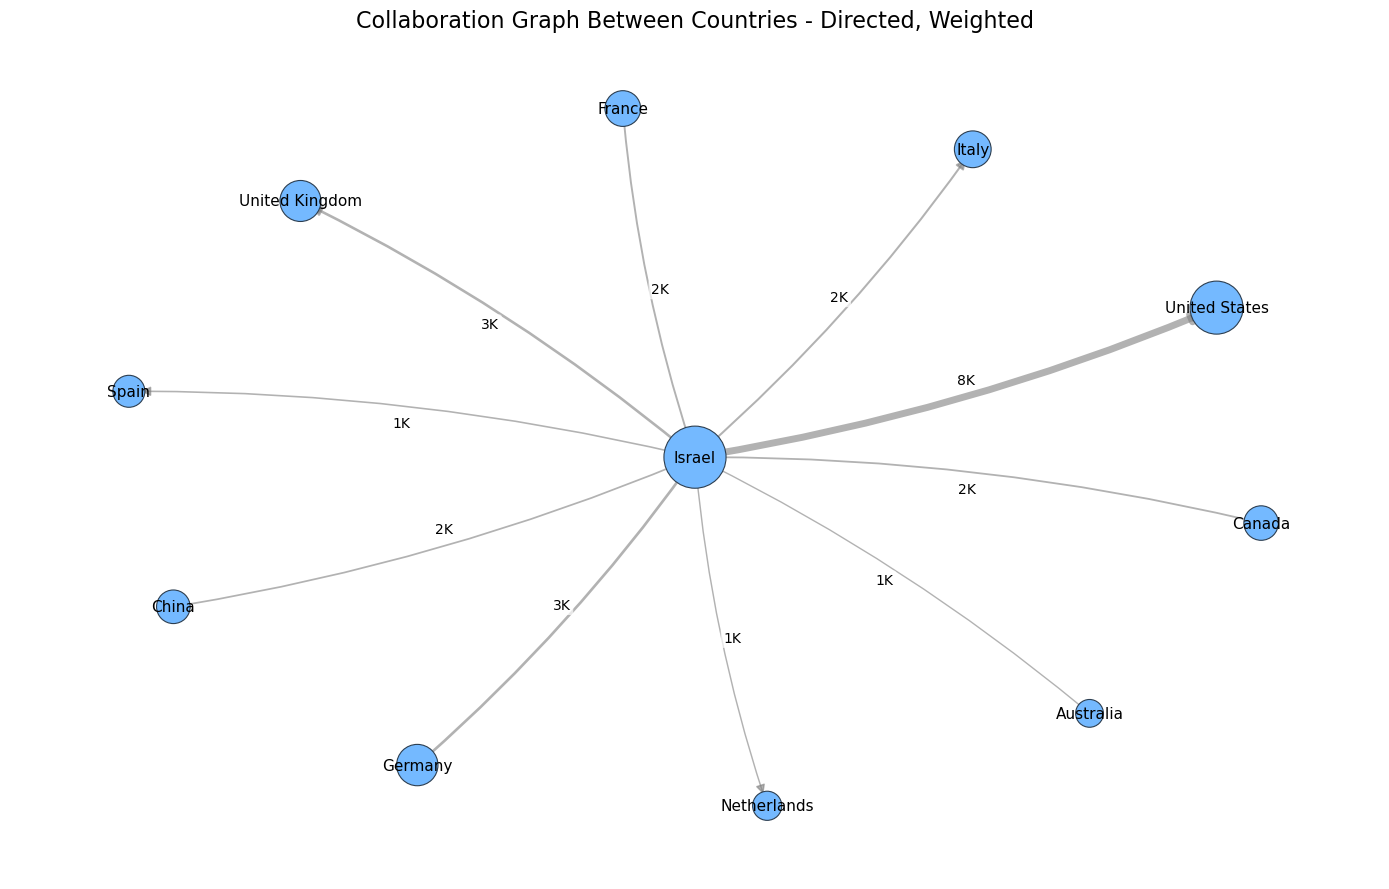

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# -------- Helpers --------
def human_format(num):
    """Format large integers as 1K, 2M, etc."""
    num = float(num)
    if num < 1000:
        return str(int(num))
    for unit in ["K", "M", "B", "T"]:
        num /= 1000.0
        if abs(num) < 1000.0:
            return f"{num:.0f}{unit}"
    return f"{num:.0f}P"

def normalize_widths(weights):
    """Map numeric weights to visually reasonable edge widths."""
    weights = np.asarray(weights, dtype=float)
    if weights.size == 0:
        return []
    wmin, wmax = float(weights.min()), float(weights.max())
    if wmax <= 0:
        return np.full_like(weights, 1.0)
    # Use log scale when the dynamic range is very large
    if wmin <= 0 or (wmax / max(wmin, 1e-9) > 100):
        wlog = np.log1p(np.clip(weights, a_min=0, a_max=None))
        return 1.0 + 4.0 * (wlog - wlog.min()) / (wlog.max() - wlog.min() + 1e-9)
    return 1.0 + 4.0 * (weights - wmin) / (wmax - wmin + 1e-9)

# -------- Main plotting function --------
def plot_country_collab_graph(
    edge_list,
    title="Collaboration Graph Between Countries - Directed, Weighted",
    min_edge_weight=None,     # drop edges with weight < this value
    top_k_edges=None,         # keep only top K edges by weight
    node_strength_mode="inout"  # "in", "out", or "inout"
):
    """
    edge_list: DataFrame with columns ['year', 'country_1', 'country_2', 'weight']
    """
    # Ensure proper dtypes
    df = edge_list.copy()
    df["country_1"] = df["country_1"].astype(str)
    df["country_2"] = df["country_2"].astype(str)
    df["weight"] = df["weight"].astype(float)

    # Optional filtering
    if min_edge_weight is not None:
        df = df[df["weight"] >= float(min_edge_weight)]
    if top_k_edges is not None and top_k_edges > 0:
        df = df.nlargest(int(top_k_edges), "weight")

    # Build directed graph
    G = nx.DiGraph()
    for row in df.itertuples(index=False):
        u, v, w = row.country_1, row.country_2, float(row.weight)
        if G.has_edge(u, v):
            # In case the input is not aggregated, accumulate
            G[u][v]["weight"] += w
        else:
            G.add_edge(u, v, weight=w)

    print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    if G.number_of_nodes() == 0:
        print("Nothing to draw - no nodes after filtering.")
        return

    # Positions - use an unweighted simple graph to spread nodes more evenly
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from([(u, v) for u, v in G.edges()])
    pos = nx.spring_layout(H, k=4, iterations=300, seed=42, weight=None)

    # Edge widths
    edge_weights = [d["weight"] for _, _, d in G.edges(data=True)]
    widths = normalize_widths(edge_weights)

    # Node sizes by strength
    in_w = dict(G.in_degree(weight="weight"))
    out_w = dict(G.out_degree(weight="weight"))
    if node_strength_mode == "in":
        strength = {n: float(in_w.get(n, 0.0)) for n in G.nodes()}
    elif node_strength_mode == "out":
        strength = {n: float(out_w.get(n, 0.0)) for n in G.nodes()}
    else:
        strength = {n: float(in_w.get(n, 0.0) + out_w.get(n, 0.0)) for n in G.nodes()}

    svals = np.array(list(strength.values()), dtype=float)
    if svals.size == 0 or np.all(svals == 0):
        node_sizes = np.full(len(G), 600.0)
    else:
        slog = np.log1p(svals)
        node_sizes = 400.0 + 1600.0 * (slog - slog.min()) / (slog.max() - slog.min() + 1e-9)

    size_map = {n: s for n, s in zip(G.nodes(), node_sizes)}
    sizes_for_draw = [size_map[n] for n in G.nodes()]

    # Draw
    fig = plt.figure(figsize=(14, 9), facecolor="white")
    ax = plt.gca()
    ax.set_facecolor("white")

    # Nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=sizes_for_draw,
        node_color="#74b9ff",
        edgecolors="#2c3e50",
        linewidths=0.8
    )

    # Edges
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle="-|>", arrowsize=14,
        width=widths,
        edge_color="gray", alpha=0.6,
        connectionstyle="arc3,rad=0.06"
    )

    # Edge labels - short format
    edge_labels = {(u, v): human_format(d.get("weight", 1)) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=10, label_pos=0.52, rotate=False,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
    )

    # Node labels
    nx.draw_networkx_labels(G, pos, font_size=11)

    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_country_collab_graph(edge_list)  # basic

Extracting the key countries with which Israel collaboration for further analysis

In [48]:
import pandas as pd

def extract_non_israel_countries(df_2021_il):
    """
    Extracts pairs where Israel is either country_1 or country_2
    and returns a DataFrame with 'country' and 'value' columns.
    """
    # Filter rows where Israel appears in either country_1 or country_2
    mask = (df_2021_il['country_1'] == 'Israel') | (df_2021_il['country_2'] == 'Israel')
    df_il = df_2021_il[mask].copy()

    # Create 'country' column as the country that is not Israel
    df_il['country'] = df_il.apply(
        lambda row: row['country_2'] if row['country_1'] == 'Israel' else row['country_1'],
        axis=1
    )

    # Rename 'weight' to 'value' and keep only the needed columns
    result = df_il[['country', 'weight']].rename(columns={'weight': 'value'})

    return result

# Example usage
df_result = extract_non_israel_countries(df_2021_il)
print(df_result.head())


               country  value
240732   United States   8497
240872         Germany   2785
240878  United Kingdom   2708
240941           Italy   1937
240964          France   1796
